In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
import batman
from scipy.optimize import minimize
from scipy.signal import find_peaks
# Disclaimer: Most of this is unoriginal and ripped directly from a random online tutorial.

In [14]:
data_planet = pd.read_excel("ep206103150.xlsx")
time = data_planet['time']
flux = data_planet['flux']

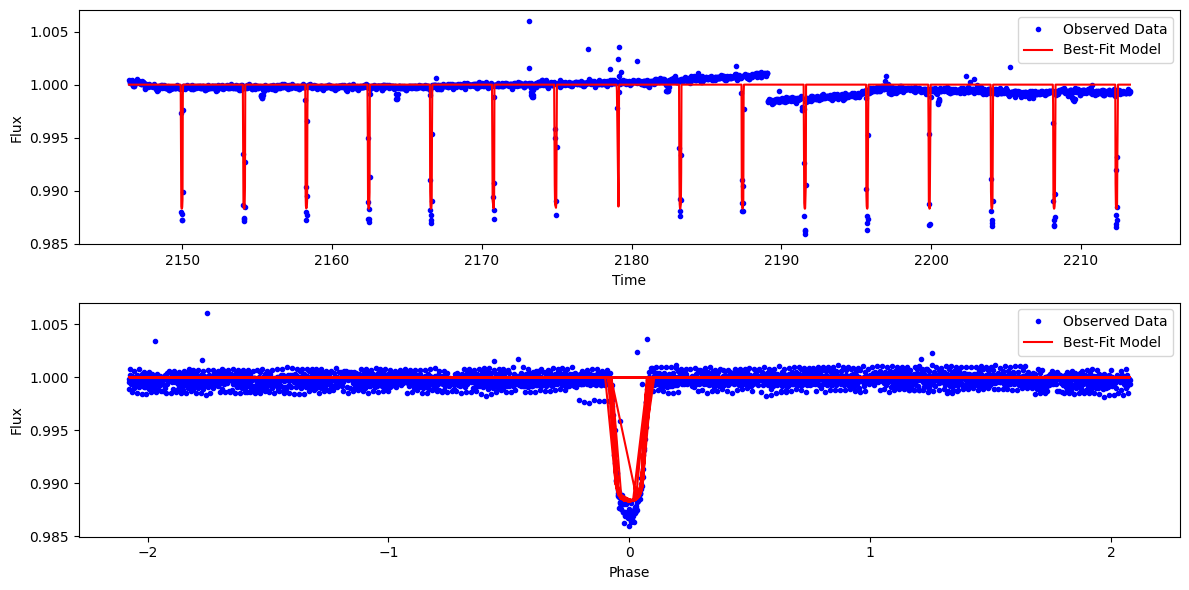

In [23]:
# Function to detect the first dip in the data
def find_first_dip(flux, prominence=0.01):
    peaks, _ = find_peaks(-flux, prominence=prominence)
    if peaks.any():
        return peaks[0]
    return None

# Define a function to fit transit parameters and generate the model light curve
def fit_transit_parameters(time, flux, initial_params):
    # Detect the first dip
    first_dip_index = find_first_dip(flux)

    if first_dip_index is not None:
        # Use the first dip as the initial transit center time
        initial_params['t0'] = time[first_dip_index]

    # Generate a finer time grid during transit for a smoother model
    time_fine = np.linspace(time[0], time[-1], len(time) * 10)

    # Define the transit model parameters
    params = batman.TransitParams()
    params.t0 = initial_params['t0']
    params.per = initial_params['per']
    params.rp = initial_params['rp']
    params.a = initial_params['a']  # Using the provided semi-major axis directly
    params.inc = initial_params['inc']
    params.ecc = initial_params['ecc']
    params.w = initial_params['w']
    params.limb_dark = "quadratic"  # Limb darkening model, you may adjust this if needed
    params.u = [0.1, 0.3]  # Example values for limb darkening, adjust as needed

    # Initialize the BATMAN transit model
    m = batman.TransitModel(params, time_fine)

    # Define a function to minimize, which calculates the residuals
    def objective(p):
        # Update parameters
        params.t0, params.per, params.rp, params.a, params.inc, params.ecc, params.w = p

        # Initialize the BATMAN transit model with updated parameters
        m = batman.TransitModel(params, time_fine)

        # Calculate the model light curve
        flux_model = m.light_curve(params)

        # Interpolate the model to match the original time grid
        flux_model = np.interp(time, time_fine, flux_model)

        # Calculate residuals
        residuals = flux - flux_model

        # Return the sum of squared residuals
        return np.sum(residuals**2)

    # Perform the optimization to find best-fit parameters (t0, per, rp, a, inc, ecc, w)
    initial_guess = [params.t0, params.per, params.rp, params.a, params.inc, params.ecc, params.w]
    bounds = [(params.t0 * 0.9, params.t0 * 1.1), (None, None), (None, None), (None, None),
              (params.inc * 0.9, params.inc * 1.1), (params.ecc * 0.9, params.ecc * 1.1),
              (params.w * 0.9, params.w * 1.1)]  # Adjust bounds as needed
    result = minimize(objective, initial_guess, method='Nelder-Mead', bounds=bounds)

    # Get the best-fit parameters
    best_fit_params = result.x
    params.t0, params.per, params.rp, params.a, params.inc, params.ecc, params.w = best_fit_params

    # Initialize the BATMAN transit model with best-fit parameters
    m = batman.TransitModel(params, time_fine)
    flux_model = m.light_curve(params)

    # Interpolate the model to match the original time grid
    flux_model = np.interp(time, time_fine, flux_model)

    return flux_model, params

# Initial parameters (provide initial guesses for the transit parameters)
initial_params = {
    't0': 2150.00,
    'per': 4.1591,
    'rp': 0.1,
    'a': 15.0,  # Change this value to match your units (semi-major axis / stellar radius)
    'inc': 87.0,
    'ecc': 0.0,
    'w': 90.0,
}

# Fit the transit parameters and generate the model light curve
model, best_fit_params = fit_transit_parameters(time_data, flux_data, initial_params)

# Plot the original and best-fit light curves
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_data, flux_data, 'b.', label='Observed Data')
plt.plot(time_data, model, 'r', label='Best-Fit Model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Flux')

# Phase fold the data
folded_time = ((time_data - best_fit_params.t0 + 0.5 * best_fit_params.per) % best_fit_params.per) - 0.5 * best_fit_params.per

# Plot the phase-folded light curve
plt.subplot(2, 1, 2)
plt.plot(folded_time, flux_data, 'b.', label='Observed Data')
plt.plot(folded_time, model, 'r', label='Best-Fit Model')
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Flux')

plt.tight_layout()
plt.show()